**0. Libraries**

In [1]:
from pathlib import Path
import re
import os
import glob
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

**1. Import the names of the image and label files**

In [2]:
# Import names of image files (option 1)
folderI = glob.glob('dataset/*.jpg')
folderI = pd.Series(folderI)

# Import names of image files (option 1)
#folderL = glob.glob("**/*-ellipseList.txt")

# Import names of label files (option 2)
def returnEllipseList(path):
    return [str(f) for f in Path(path).glob("**/*-ellipseList.txt")]

folderL = returnEllipseList('labels')

**2. Extract labels from all files**

In [3]:
def extractLabelsFromFile(file_name):
    with open(file_name, 'r') as f:
        return f.read().splitlines()

labels = []
for file_name in folderL:
    labels += extractLabelsFromFile(file_name)

**3. Extract labels data from labels list**

In [4]:
def transformCoordinates(major, minor, angle, x, y, max_x, max_y):
    w = 2 * max(abs(major * math.cos(angle)), abs(minor * math.sin(angle)))
    h = 2 * max(abs(major * math.sin(angle)), abs(minor * math.cos(angle)))
    
    x = x - w/2
    y = y - h/2
    
    if x < 0:
        w = w + x
        x = 0
    if y < 0:
        h = h + y
        y = 0
    if x > max_x:
        x = max_x
    if y > max_y:
        y = max_y
        
    if x + w > max_x:
        w = max_x - x
    if y + h > max_y:
        h = max_y - y
        
    return int(x), int(y), int(w), int(h)

def parseLabelsList(labels):
    i = 0
    arrImageData = []
    rg = re.compile('(\d)*_(\d)*_(\d)*_big')
    
    #Iterate over each label
    while (i < len(labels)):
        #Search for the file name
        if rg.match(labels[i]):
            try:
                currImage = dict()
                
                img_name = "{}.jpg".format(labels[i])
                n = int(labels[i+1]) # Get number of faces
                sig = i+2 + n       # Calculate line of next image name
                
                #Read image and dimensions (matplotlib)
                img = mpimg.imread(os.path.join("dataset", img_name))
                (h, w, _) = img.shape
                
                #Plot image (matplotlib)
                #fig, ax = plt.subplots(1)
                #ax.imshow(img)
                
                #Fill currImage data
                currImage['name'] = img_name
                currImage['coordinates'] = []
                currImage['size'] = {'height': h, 'width': w}
                
                #Iterate to parse data of each face
                for currL in labels[i+2:sig]:
                    (major, minor, angle, x, y, _, _) = currL.split(' ')
                    x, y, w, h = transformCoordinates(
                        float(major), float(minor), float(angle),
                        float(x), float(y), float(w), float(h)
                    )

                    #Plot current rectangle (mathplotlib)
                    #rect = patches.Rectangle(
                    #    (x, y), w, h,
                    #    linewidth=1,
                    #    edgecolor='r',
                    #    facecolor='none'
                    #)
                    #ax.add_patch(rect)
                    
                    #Append the data of current rectangle
                    currImage['coordinates'].append({'x':x, 'y':y, 'width':w, 'height':h})
                
                
                #plt.show() # Display the current image with its rectangles (matplotlib)
                arrImageData.append(currImage)
                i = sig             # Jump to next image name
            except Exception as e:
                #print("Couldn't load {} because {}".format(img_name, e))
                i+=1
        else:
            i+=1
    return arrImageData

arrImageData = parseLabelsList(labels)

**4. Plot some images to test your labels**

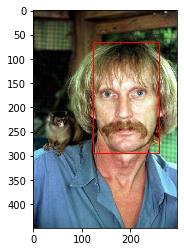

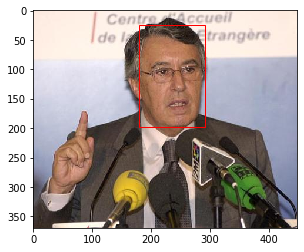

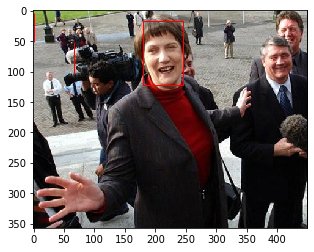

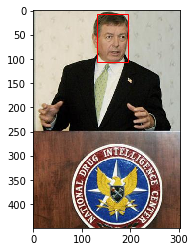

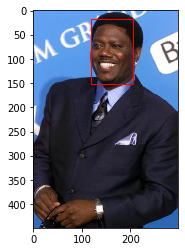

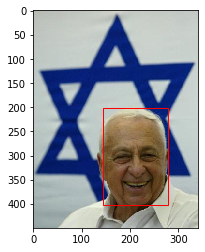

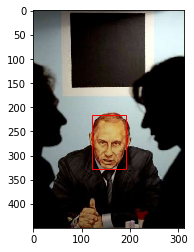

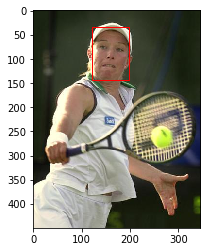

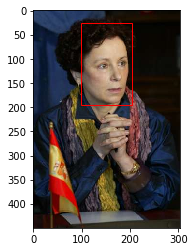

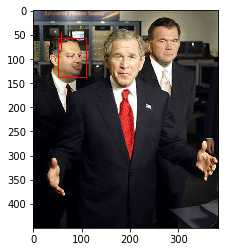

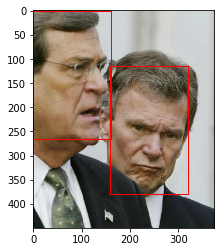

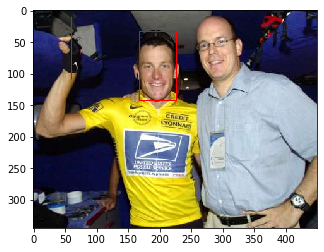

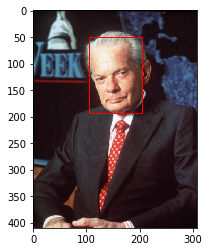

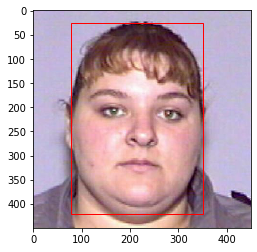

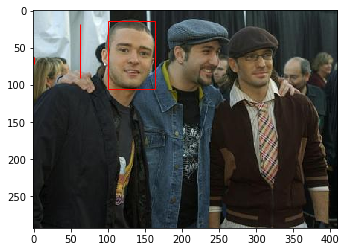

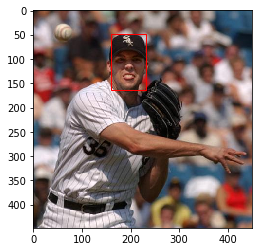

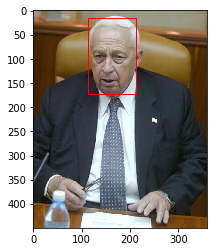

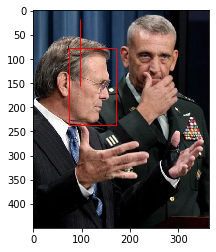

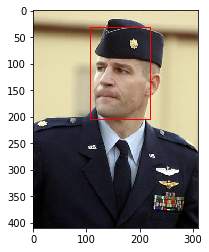

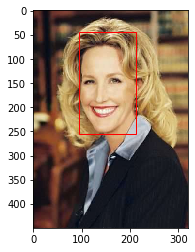

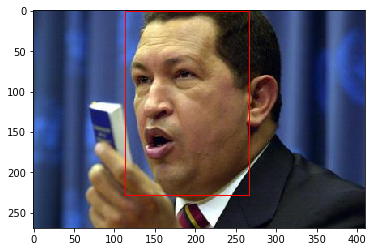

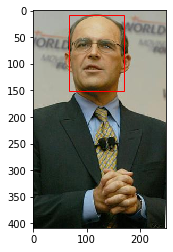

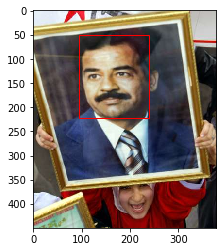

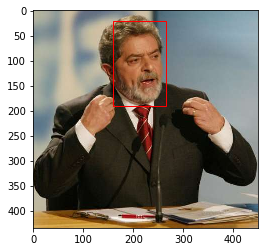

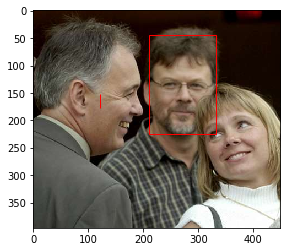

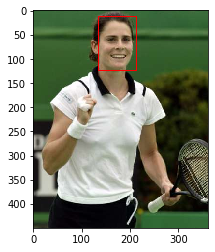

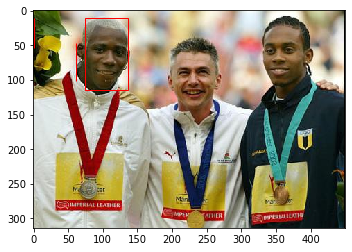

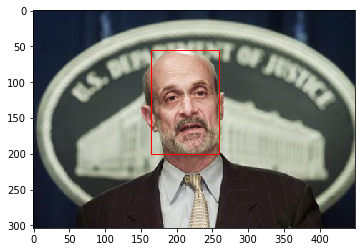

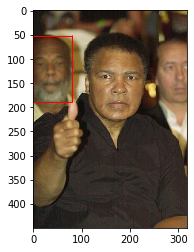

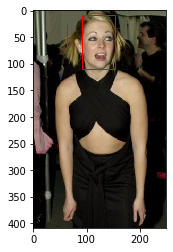

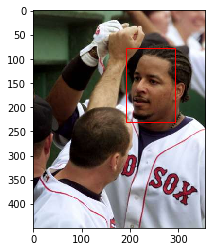

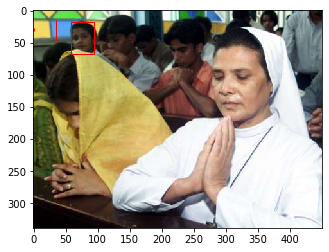

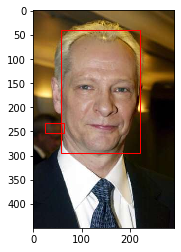

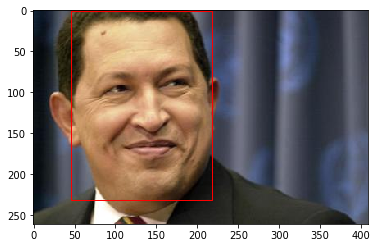

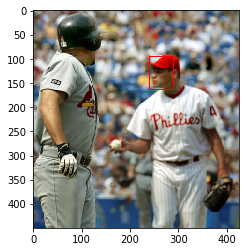

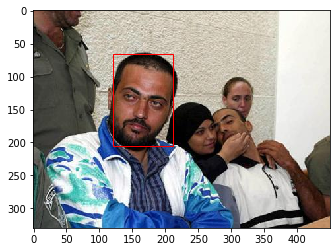

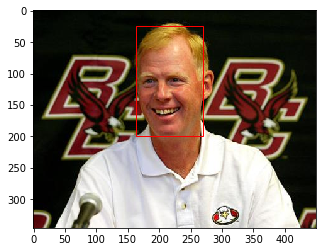

In [6]:
def plotLabels(arrImageData):
    for currImg in arrImageData:
        #Read image and dimensions (matplotlib)
        img = mpimg.imread(os.path.join("dataset", currImg['name']))

        #Plot image (matplotlib)
        fig, ax = plt.subplots(1)
        ax.imshow(img)

        for c in currImg['coordinates']:
            #Plot current rectangle (mathplotlib)
            rect = patches.Rectangle(
                (c['x'], c['y']), c['width'], c['height'],
                linewidth=1,
                edgecolor='r',
                facecolor='none'
            )
            ax.add_patch(rect)
        plt.show()

plotLabels(arrImageData[133:170])

**5. Code labels data into xml files** (in process)

In [ ]:
def pdToXml(name, coordinates, size, img_folder):
    xml = ['<annotation>']
    xml.append("    <folder>{}</folder>".format(img_folder))
    xml.append("    <filename>{}</filename>".format(name))
    xml.append("    <source>")
    xml.append("        <database>Unknown</database>")
    xml.append("    </source>")
    xml.append("    <size>")
    xml.append("        <width>{}</width>".format(size["width"]))
    xml.append("        <height>{}</height>".format(size["height"]))
    xml.append("        <depth>3</depth>".format())
    xml.append("    </size>")
    xml.append("    <segmented>0</segmented>")

    for field in coordinates:
        xmin, ymin = max(0,field[0]), max(0,field[1])
        xmax = min(size["width"], field[0]+field[2])
        ymax = min(size["height"], field[1]+field[3])

        xml.append("    <object>")
        xml.append("        <name>Face</name>")
        xml.append("        <pose>Unspecified</pose>")
        xml.append("        <truncated>0</truncated>")
        xml.append("        <difficult>0</difficult>")
        xml.append("        <bndbox>")
        xml.append("            <xmin>{}</xmin>".format(int(xmin)))
        xml.append("            <ymin>{}</ymin>".format(int(ymin)))
        xml.append("            <xmax>{}</xmax>".format(int(xmax)))
        xml.append("            <ymax>{}</ymax>".format(int(ymax)))
        xml.append("        </bndbox>")
        xml.append("    </object>")
    xml.append('</annotation>')
    return '\n'.join(xml)